In [1]:
# 清理环境信息，与上课内容无关
import os
os.environ["LANGCHAIN_PROJECT"] = ""
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_ENDPOINT"] = ""
os.environ["LANGCHAIN_TRACING_V2"] = ""

In [ ]:
# 安装所需要使用的包
!pip install openai langgraph Agently==3.3.1.9 mermaid-python nest_asyncio

# 因为本课使用的langgraph可能需要依赖langchain 0.2.10版本，但其他课件依赖langchain 0.1.20版本
# 请学习完本课之后对langchain进行降级，以免在其他课程出现运行错误
#!pip install langchain==0.1.20
#!pip install langchain-openai==0.1.6
#!pip install langchain-community==0.0.38

In [3]:
# 使用nest_asyncio确保异步稳定性
import nest_asyncio
nest_asyncio.apply()

## 💡 这节课会带给你

1. 了解工作流对大模型进行高质量工作的辅助意义
2. 学会复现吴恩达博士的翻译工作流开源项目
3. 了解构成大模型工作流系统的关键元素
4. 学会搭建一个更复杂的故事创作工作流

## 🎓 这节课怎么学

代码能力要求：**中**，AI/数学基础要求：**低**

1. 有编程基础的同学
    - 能够自己动手实现一套复杂的大模型工作流
2. 没有编程基础的同学
    - 可以关注和理解工作流对于大模型应用的意义、关键元素和构建思路
    - 不需要复杂编程知识，可以尝试复现简单的翻译工作流

## 一、为什么我们需要工作流？

### ❓ 哪些因素会影响大模型应用的效果？

- 模型能力（智力）
    - 通识理解和泛化能力
    - 输入信息理解、推理、规划、执行能力
    - 输入信息补充知识学习能力
    - 文字生成创作的风格
- 相关信息（知识）
    - 与任务相关的信息
    - 与互动背景相关的信息
- 模型输出控制（行动方法）
    - 单次请求控制
        - Prompt表达优化
        - 以CoT为代表的思维链控制方法
        - 输出格式控制（文本格式语法、工程结构化数据输出…）
    - 多次请求控制
        - 以ReAct（Action-Observation-Reflection）为代表的多轮自我反思优化
        - 复杂任务的执行过程编排管理

### 单次请求的局限性

- 上下文窗口长度限制、输出长度限制（早期的LangChain长文本Summarize）
- 直接进行CoT控制（尤其是用自然语言表达CoT）会输出思考过程，但我们不希望用户看到这个过程
- 随着工作进展出现的新信息，对任务时序、编排有依赖的信息，不一定能在单次请求中一次性完成输入

### 工作流的优势

- 将工作任务拆分成多个工作节点
- 能够将模型单次请求调用视作一个工作节点
- 能够灵活将其他代码逻辑也写入工作节点
- 能够对工作节点进行任务编排
- 能够在工作节点之间进行数据传递

[试一试]

直接请求模型的效果：

In [3]:
from ENV import deep_seek_url, deep_seek_api_key, deep_seek_default_model
import Agently
agent = (
    Agently.create_agent()
        .set_settings("current_model", "OAIClient")
        .set_settings("model.OAIClient.url", deep_seek_url)
        .set_settings("model.OAIClient.auth", { "api_key": deep_seek_api_key })
        .set_settings("model.OAIClient.options", { "model": deep_seek_default_model })
)

result = agent.input(input("[请输入您的要求]: ")).start()
print("[回复]: ", result)

[请输入您的要求]:  我想要退货，这个鞋子不合脚


[回复]:  如果您购买的鞋子不合脚，并且您希望退货，以下是一些一般性的步骤和建议，但请注意，具体的退货政策可能因购买地点、品牌或销售商而异：

1. **检查退货政策**：首先，查看您购买鞋子时收到的收据或电子邮件，了解销售商的退货政策。通常，退货政策会说明退货的时间限制、是否需要保持商品的原始状态、是否需要提供购买凭证等。

2. **联系客服**：如果退货政策允许退货，您应该联系销售商的客服部门。您可以通过电话、电子邮件或在线聊天与他们联系，说明您的情况并询问退货的具体流程。

3. **准备退货物品**：根据退货政策，您可能需要将鞋子放回原始包装中，并确保鞋子没有磨损或损坏。有些销售商可能还要求您提供退货授权号码（RMA）。

4. **邮寄或亲自退货**：根据销售商的要求，您可能需要将鞋子邮寄回去，或者亲自带到商店退货。如果是邮寄退货，请确保使用可追踪的邮寄方式，并保留邮寄凭证，以防万一需要证明您已经退货。

5. **等待退款**：一旦销售商收到并检查了退货商品，他们将处理您的退款。退款通常会退回到您最初用于支付的信用卡或账户中。

请记住，每个销售商的退货流程可能有所不同，因此最好直接咨询您购买鞋子的具体销售商以获取最准确的退货信息。如果您是在线购买的，通常网站上会有详细的退货指南和联系方式。


使用工作流：

In [7]:
workflow = Agently.Workflow()

@workflow.chunk()
def user_input(inputs, storage):
    storage.set("user_input", input("[请输入您的要求]: "))
    return

@workflow.chunk()
def judge_intent_and_quick_reply(inputs, storage):
    result = (
        agent
            .input(storage.get("user_input"))
            .output({
                "user_intent": ("闲聊 | 售后问题 | 其他", "判断用户提交的{input}内容属于给定选项中的哪一种"),
                "quick_reply": (
                    "str",
"""如果{user_intent}=='闲聊'，那么直接给出你的回应；
如果{user_intent}=='售后问题'，那么请用合适的方式告诉用户你已经明白用户的诉求，安抚客户情绪并请稍等你去看看应该如何处理；
如果{user_intent}=='其他'，此项输出null""")
            })
            .start()
    )
    storage.set("reply", result["quick_reply"])
    return result["user_intent"]

@workflow.chunk()
def generate_after_sales_reply(inputs, storage):
    storage.set("reply", (
        agent
            .input(storage.get("user_input"))
            .instruct(
"""请根据{input}的要求，以一个专业客户服务人员的角色给出回复，遵循如下模板进行回复：
亲爱的客户，感谢您的耐心等待。
我理解您希望{{复述客户的要求}}，是因为{{复述客户要求提出要求的理由}}，您的心情一定非常{{阐述你对客户心情/感受的理解}}。
{{给出对客户当前心情的抚慰性话语}}。
我们会尽快和相关人员沟通，并尽量进行满足。请留下您的联系方式以方便我们尽快处理后与您联系。
"""
)
            .start()
    ))
    return

@workflow.chunk()
def generate_other_topic_reply(inputs, storage):
    storage.set("reply", "我们好像不应该聊这个，还是回到您的问题或诉求上来吧。")
    return

@workflow.chunk_class()
def reply(inputs, storage):
    print("[回复]: ", storage.get("reply"))
    return

(
    workflow
        .connect_to("user_input")
        .connect_to("judge_intent_and_quick_reply")
        .if_condition(lambda return_value, storage: return_value=="闲聊")
            .connect_to("@reply")
            .connect_to("end")
        .elif_condition(lambda return_value, storage: return_value=="售后问题")
            .connect_to("@reply")
            .connect_to("generate_after_sales_reply")
            .connect_to("@reply")
            .connect_to("END")
        .else_condition()
            .connect_to("generate_other_topic_reply")
            .connect_to("@reply")
            .connect_to("END")
)

workflow.start()

[请输入您的要求]:  我想要退货，这个鞋子不合脚


[回复]:  非常抱歉您遇到了这样的问题，我完全理解您的不便。请稍等，我将立即查看如何为您处理退货事宜。
[回复]:  亲爱的客户，感谢您的耐心等待。
我理解您希望退货，是因为鞋子不合脚，您的心情一定非常失望。
请您放心，我们非常重视您的购物体验，对于给您带来的不便我们深感抱歉。
我们会尽快和相关人员沟通，并尽量进行满足。请留下您的联系方式以方便我们尽快处理后与您联系。


{'default': None}

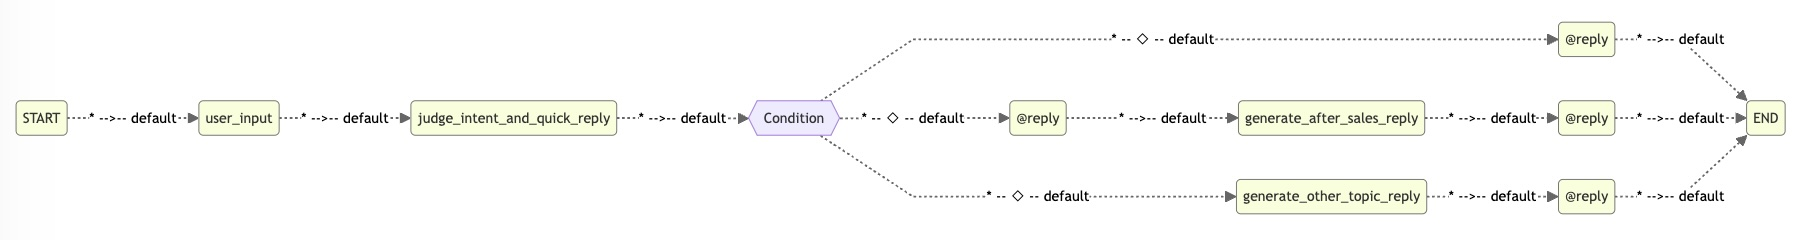

## 二、让我们从吴恩达博士的开源翻译工作流项目说起

- 项目地址：[https://github.com/andrewyng/translation-agent](https://github.com/andrewyng/translation-agent)

- 项目基本思路：

    - 让模型在完成首轮翻译之后，通过自我反思后修正的工作流优化翻译结果，以提升最终文本翻译的质量
 
- 关键步骤：

    1. 第一步：
       
        - 输入信息：**原始文本语言(source_lang)** 、**翻译目标语言(target_lang)** 和 **原始文本(source_text)**
        - 角色设定：以翻译文本为任务目标的语言学家
        - 输出结果：基于所有输入信息，对 **原始文本(source_text)** 进行 **第一轮翻译的结果(translation_1)**；
  
    2. 第二步：
       
        - 输入信息：**原始文本语言(source_lang)** 、**翻译目标语言(target_lang)** 、 **原始文本(source_text)** 和 **第一轮翻译结果(translation_1)**
        - 角色设定：以阅读原始文本和翻译文本，并给出翻译改进意见为任务目标的语言学家
        - 输出结果：基于所有输入信息，对 **第一轮翻译结果(translation_1)** 提出的 **改进意见反思(reflection)**
  
    3. 第三步：
       
        - 输入信息：**原始文本语言(source_lang)** 、**翻译目标语言(target_lang)** 、 **原始文本(source_text)** 、 **第一轮翻译结果(translation_1)** 和 **改进意见反思(reflection)**
        - 角色设定：以翻译文本为任务目标的语言学家（和第一步相同）
        - 输出结果：基于所有输入信息，给出的**第二轮优化后翻译结果(translation_2)**

- 关键代码文件：[https://github.com/andrewyng/translation-agent/blob/main/src/translation_agent/utils.py](https://github.com/andrewyng/translation-agent/blob/main/src/translation_agent/utils.py)
  
- 关键代码片段：

In [4]:
def one_chunk_initial_translation(
    source_lang: str, target_lang: str, source_text: str
) -> str:
    """
    Translate the entire text as one chunk using an LLM.

    Args:
        source_lang (str): The source language of the text.
        target_lang (str): The target language for translation.
        source_text (str): The text to be translated.

    Returns:
        str: The translated text.
    """

    system_message = f"You are an expert linguist, specializing in translation from {source_lang} to {target_lang}."

    translation_prompt = f"""This is an {source_lang} to {target_lang} translation, please provide the {target_lang} translation for this text. \
Do not provide any explanations or text apart from the translation.
{source_lang}: {source_text}

{target_lang}:"""

    prompt = translation_prompt.format(source_text=source_text)

    translation = get_completion(prompt, system_message=system_message)

    return translation


def one_chunk_reflect_on_translation(
    source_lang: str,
    target_lang: str,
    source_text: str,
    translation_1: str,
    country: str = "",
) -> str:
    """
    Use an LLM to reflect on the translation, treating the entire text as one chunk.

    Args:
        source_lang (str): The source language of the text.
        target_lang (str): The target language of the translation.
        source_text (str): The original text in the source language.
        translation_1 (str): The initial translation of the source text.
        country (str): Country specified for target language.

    Returns:
        str: The LLM's reflection on the translation, providing constructive criticism and suggestions for improvement.
    """

    system_message = f"You are an expert linguist specializing in translation from {source_lang} to {target_lang}. \
You will be provided with a source text and its translation and your goal is to improve the translation."

    if country != "":
        reflection_prompt = f"""Your task is to carefully read a source text and a translation from {source_lang} to {target_lang}, and then give constructive criticism and helpful suggestions to improve the translation. \
The final style and tone of the translation should match the style of {target_lang} colloquially spoken in {country}.

The source text and initial translation, delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT> and <TRANSLATION></TRANSLATION>, are as follows:

<SOURCE_TEXT>
{source_text}
</SOURCE_TEXT>

<TRANSLATION>
{translation_1}
</TRANSLATION>

When writing suggestions, pay attention to whether there are ways to improve the translation's \n\
(i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),\n\
(ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules, and ensuring there are no unnecessary repetitions),\n\
(iii) style (by ensuring the translations reflect the style of the source text and takes into account any cultural context),\n\
(iv) terminology (by ensuring terminology use is consistent and reflects the source text domain; and by only ensuring you use equivalent idioms {target_lang}).\n\

Write a list of specific, helpful and constructive suggestions for improving the translation.
Each suggestion should address one specific part of the translation.
Output only the suggestions and nothing else."""

    else:
        reflection_prompt = f"""Your task is to carefully read a source text and a translation from {source_lang} to {target_lang}, and then give constructive criticism and helpful suggestions to improve the translation. \

The source text and initial translation, delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT> and <TRANSLATION></TRANSLATION>, are as follows:

<SOURCE_TEXT>
{source_text}
</SOURCE_TEXT>

<TRANSLATION>
{translation_1}
</TRANSLATION>

When writing suggestions, pay attention to whether there are ways to improve the translation's \n\
(i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),\n\
(ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules, and ensuring there are no unnecessary repetitions),\n\
(iii) style (by ensuring the translations reflect the style of the source text and takes into account any cultural context),\n\
(iv) terminology (by ensuring terminology use is consistent and reflects the source text domain; and by only ensuring you use equivalent idioms {target_lang}).\n\

Write a list of specific, helpful and constructive suggestions for improving the translation.
Each suggestion should address one specific part of the translation.
Output only the suggestions and nothing else."""

    prompt = reflection_prompt.format(
        source_lang=source_lang,
        target_lang=target_lang,
        source_text=source_text,
        translation_1=translation_1,
    )
    reflection = get_completion(prompt, system_message=system_message)
    return reflection


def one_chunk_improve_translation(
    source_lang: str,
    target_lang: str,
    source_text: str,
    translation_1: str,
    reflection: str,
) -> str:
    """
    Use the reflection to improve the translation, treating the entire text as one chunk.

    Args:
        source_lang (str): The source language of the text.
        target_lang (str): The target language for the translation.
        source_text (str): The original text in the source language.
        translation_1 (str): The initial translation of the source text.
        reflection (str): Expert suggestions and constructive criticism for improving the translation.

    Returns:
        str: The improved translation based on the expert suggestions.
    """

    system_message = f"You are an expert linguist, specializing in translation editing from {source_lang} to {target_lang}."

    prompt = f"""Your task is to carefully read, then edit, a translation from {source_lang} to {target_lang}, taking into
account a list of expert suggestions and constructive criticisms.

The source text, the initial translation, and the expert linguist suggestions are delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT>, <TRANSLATION></TRANSLATION> and <EXPERT_SUGGESTIONS></EXPERT_SUGGESTIONS> \
as follows:

<SOURCE_TEXT>
{source_text}
</SOURCE_TEXT>

<TRANSLATION>
{translation_1}
</TRANSLATION>

<EXPERT_SUGGESTIONS>
{reflection}
</EXPERT_SUGGESTIONS>

Please take into account the expert suggestions when editing the translation. Edit the translation by ensuring:

(i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),
(ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules and ensuring there are no unnecessary repetitions), \
(iii) style (by ensuring the translations reflect the style of the source text)
(iv) terminology (inappropriate for context, inconsistent use), or
(v) other errors.

Output only the new translation and nothing else."""

    translation_2 = get_completion(prompt, system_message)

    return translation_2


def one_chunk_translate_text(
    source_lang: str, target_lang: str, source_text: str, country: str = ""
) -> str:
    """
    Translate a single chunk of text from the source language to the target language.

    This function performs a two-step translation process:
    1. Get an initial translation of the source text.
    2. Reflect on the initial translation and generate an improved translation.

    Args:
        source_lang (str): The source language of the text.
        target_lang (str): The target language for the translation.
        source_text (str): The text to be translated.
        country (str): Country specified for target language.
    Returns:
        str: The improved translation of the source text.
    """
    translation_1 = one_chunk_initial_translation(
        source_lang, target_lang, source_text
    )

    reflection = one_chunk_reflect_on_translation(
        source_lang, target_lang, source_text, translation_1, country
    )
    translation_2 = one_chunk_improve_translation(
        source_lang, target_lang, source_text, translation_1, reflection
    )

    return translation_2

## 三、使用LangGraph和Agently Workflow分别复现这个工作流

### 3.1 LangGraph

LangGraph手册：[https://langchain-ai.github.io/langgraph/](https://langchain-ai.github.io/langgraph/)

In [ ]:
import json
import openai
from ENV import deep_seek_url, deep_seek_api_key, deep_seek_default_model
from langgraph.graph import StateGraph, START, END
import os

# 模型请求准备
client = openai.OpenAI(
    api_key = deep_seek_api_key,
    base_url =deep_seek_url
)
default_model = deep_seek_default_model

def get_completion(
    prompt: str,
    system_message: str = "You are a helpful assistant.",
    model: str = default_model,
    temperature: float = 0.3,
    json_mode: bool = False,
):
    response = client.chat.completions.create(
        model=model,
        temperature=temperature,
        top_p=1,
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt},
        ],
    )
    return response.choices[0].message.content

# 定义传递的信息结构
from typing import TypedDict, Optional
class State(TypedDict):
    source_lang: str
    target_lang: str
    source_text: str
    country: Optional[str] = None
    translation_1: Optional[str] = None
    reflection: Optional[str] = None
    translation_2: Optional[str] = None

# 创建一个工作流对象
workflow = StateGraph(State)

# 定义三个工作块
"""
获取state中的信息：state.get("key_name")
更新state中的信息：return { "key_name": new_value }
"""
def initial_translation(state):
    source_lang = state.get("source_lang")
    target_lang = state.get("target_lang")
    source_text = state.get("source_text")

    system_message = f"You are an expert linguist, specializing in translation from {source_lang} to {target_lang}."

    prompt = f"""This is an {source_lang} to {target_lang} translation, please provide the {target_lang} translation for this text. \
Do not provide any explanations or text apart from the translation.
{source_lang}: {source_text}

{target_lang}:"""

    translation = get_completion(prompt, system_message=system_message)

    print("[初次翻译结果]: \n", translation)

    return { "translation_1": translation }

def reflect_on_translation(state):
    source_lang = state.get("source_lang")
    target_lang = state.get("target_lang")
    source_text = state.get("source_text")
    country = state.get("country") or ""
    translation_1 = state.get("translation_1")
    
    system_message = f"You are an expert linguist specializing in translation from {source_lang} to {target_lang}. \
You will be provided with a source text and its translation and your goal is to improve the translation."

    additional_rule = (
        f"The final style and tone of the translation should match the style of {target_lang} colloquially spoken in {country}."
        if country != ""
        else ""
    )
    
    prompt = f"""Your task is to carefully read a source text and a translation from {source_lang} to {target_lang}, and then give constructive criticism and helpful suggestions to improve the translation. \
{additional_rule}

The source text and initial translation, delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT> and <TRANSLATION></TRANSLATION>, are as follows:

<SOURCE_TEXT>
{source_text}
</SOURCE_TEXT>

<TRANSLATION>
{translation_1}
</TRANSLATION>

When writing suggestions, pay attention to whether there are ways to improve the translation's \n\
(i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),\n\
(ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules, and ensuring there are no unnecessary repetitions),\n\
(iii) style (by ensuring the translations reflect the style of the source text and takes into account any cultural context),\n\
(iv) terminology (by ensuring terminology use is consistent and reflects the source text domain; and by only ensuring you use equivalent idioms {target_lang}).\n\

Write a list of specific, helpful and constructive suggestions for improving the translation.
Each suggestion should address one specific part of the translation.
Output only the suggestions and nothing else."""

    reflection = get_completion(prompt, system_message=system_message)

    print("[初次翻译结果]: \n", reflection)

    return { "reflection": reflection }

def improve_translation(state):
    source_lang = state.get("source_lang")
    target_lang = state.get("target_lang")
    source_text = state.get("source_text")
    translation_1 = state.get("translation_1")
    reflection = state.get("reflection")
    
    system_message = f"You are an expert linguist, specializing in translation editing from {source_lang} to {target_lang}."

    prompt = f"""Your task is to carefully read, then edit, a translation from {source_lang} to {target_lang}, taking into
account a list of expert suggestions and constructive criticisms.

The source text, the initial translation, and the expert linguist suggestions are delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT>, <TRANSLATION></TRANSLATION> and <EXPERT_SUGGESTIONS></EXPERT_SUGGESTIONS> \
as follows:

<SOURCE_TEXT>
{source_text}
</SOURCE_TEXT>

<TRANSLATION>
{translation_1}
</TRANSLATION>

<EXPERT_SUGGESTIONS>
{reflection}
</EXPERT_SUGGESTIONS>

Please take into account the expert suggestions when editing the translation. Edit the translation by ensuring:

(i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),
(ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules and ensuring there are no unnecessary repetitions), \
(iii) style (by ensuring the translations reflect the style of the source text)
(iv) terminology (inappropriate for context, inconsistent use), or
(v) other errors.

Output only the new translation and nothing else."""

    translation_2 = get_completion(prompt, system_message)

    print("[初次翻译结果]: \n", translation_2)

    return { "translation_2": translation_2 }

# 规划执行任务
## 节点（node）注册
workflow.add_node("initial_translation", initial_translation)
workflow.add_node("reflect_on_translation", reflect_on_translation)
workflow.add_node("improve_translation", improve_translation)
## 连接节点
workflow.set_entry_point("initial_translation")
#workflow.add_edge(START, )
workflow.add_edge("initial_translation", "reflect_on_translation")
workflow.add_edge("reflect_on_translation", "improve_translation")
workflow.add_edge("improve_translation", END)

# 开始执行
app = workflow.compile()
result = app.invoke({
    "source_lang": "English",
    "target_lang": "中文",
    "source_text": """Translation Agent: Agentic translation using reflection workflow
This is a Python demonstration of a reflection agentic workflow for machine translation. The main steps are:

Prompt an LLM to translate a text from source_language to target_language;
Have the LLM reflect on the translation to come up with constructive suggestions for improving it;
Use the suggestions to improve the translation.
Customizability
By using an LLM as the heart of the translation engine, this system is highly steerable. For example, by changing the prompts, it is easier using this workflow than a traditional machine translation (MT) system to:

Modify the output's style, such as formal/informal.
Specify how to handle idioms and special terms like names, technical terms, and acronyms. For example, including a glossary in the prompt lets you make sure particular terms (such as open source, H100 or GPU) are translated consistently.
Specify specific regional use of the language, or specific dialects, to serve a target audience. For example, Spanish spoken in Latin America is different from Spanish spoken in Spain; French spoken in Canada is different from how it is spoken in France.
This is not mature software, and is the result of Andrew playing around with translations on weekends the past few months, plus collaborators (Joaquin Dominguez, Nedelina Teneva, John Santerre) helping refactor the code.

According to our evaluations using BLEU score on traditional translation datasets, this workflow is sometimes competitive with, but also sometimes worse than, leading commercial offerings. However, we’ve also occasionally gotten fantastic results (superior to commercial offerings) with this approach. We think this is just a starting point for agentic translations, and that this is a promising direction for translation, with significant headroom for further improvement, which is why we’re releasing this demonstration to encourage more discussion, experimentation, research and open-source contributions.

If agentic translations can generate better results than traditional architectures (such as an end-to-end transformer that inputs a text and directly outputs a translation) -- which are often faster/cheaper to run than our approach here -- this also provides a mechanism to automatically generate training data (parallel text corpora) that can be used to further train and improve traditional algorithms. (See also this article in The Batch on using LLMs to generate training data.)

Comments and suggestions for how to improve this are very welcome!"""
})

print(result)

In [6]:
# 绘制流程图
from mermaid import Mermaid
Mermaid(app.get_graph().draw_mermaid())

### 3.2 Agently Workflow

- Agently官网：[Agently.cn](https://Agently.cn)
- Agently Workflow与LangGraph的详细比较：[点击查看](https://github.com/Maplemx/Agently/blob/main/playground/constrast_between_Agently_workflow_and_LangGraph.ipynb)

In [15]:
import json
from ENV import deep_seek_url, deep_seek_api_key, deep_seek_default_model
import Agently
import os 

# 将模型请求配置设置到agent工厂，后续工厂创建的agent对象都可以继承这个配置
agent_factory = (
    Agently.AgentFactory()
        .set_settings("current_model", "OAIClient")
        .set_settings("model.OAIClient.url", deep_seek_url)
        .set_settings("model.OAIClient.auth", { "api_key": deep_seek_api_key })
        .set_settings("model.OAIClient.options", { "model": deep_seek_default_model })
)

# 创建工作流
workflow = Agently.Workflow()

# 定义关键处理节点
## 首次翻译
@workflow.chunk()
def initial_translation(inputs, storage):
    source_lang = storage.get("source_lang")
    target_lang = storage.get("target_lang")
    source_text = storage.get("source_text")

    # 创建一个翻译agent来执行任务
    translate_agent = agent_factory.create_agent()
    
    # 给翻译agent设置system信息
    translate_agent.set_agent_prompt(
        "role",
        f"You are an expert linguist, specializing in translation from {source_lang} to {target_lang}."
    )

    # 向翻译agent发起翻译任务请求
    translation_1 = (
        translate_agent
        .input(
f"""This is an {source_lang} to {target_lang} translation, please provide the {target_lang} translation for this text. \
Do not provide any explanations or text apart from the translation.
{source_lang}: {source_text}

{target_lang}:"""
        )
        .start()
    )

    # 保存翻译结果
    storage.set("translation_1", translation_1)
    # 保存翻译agent备用
    storage.set("translate_agent", translate_agent)
    return {
        "stage": "initial translation",
        "result": translation_1
    }

## 反思优化
@workflow.chunk()
def reflect_on_translation(inputs, storage):
    source_lang = storage.get("source_lang")
    target_lang = storage.get("target_lang")
    source_text = storage.get("source_text")
    country = storage.get("country", "")
    translation_1 = storage.get("translation_1")

    # 创建一个反思agent来执行任务
    reflection_agent = agent_factory.create_agent()

    # 给反思agent设置system信息
    reflection_agent.set_agent_prompt(
        "role",
        f"You are an expert linguist specializing in translation from {source_lang} to {target_lang}. \
You will be provided with a source text and its translation and your goal is to improve the translation."
    )

    additional_rule = (
        "The final style and tone of the translation should match the style of {target_lang} colloquially spoken in {country}."
        if country != ""
        else ""
    )

    # 向反思agent发起反思任务
    reflection = (
        reflection_agent
            .input(
f"""Your task is to carefully read a source text and a translation from {source_lang} to {target_lang}, and then give constructive criticism and helpful suggestions to improve the translation. \
{additional_rule}

The source text and initial translation, delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT> and <TRANSLATION></TRANSLATION>, are as follows:

<SOURCE_TEXT>
{source_text}
</SOURCE_TEXT>

<TRANSLATION>
{translation_1}
</TRANSLATION>

When writing suggestions, pay attention to whether there are ways to improve the translation's \n\
(i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),\n\
(ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules, and ensuring there are no unnecessary repetitions),\n\
(iii) style (by ensuring the translations reflect the style of the source text and takes into account any cultural context),\n\
(iv) terminology (by ensuring terminology use is consistent and reflects the source text domain; and by only ensuring you use equivalent idioms {target_lang}).\n\

Write a list of specific, helpful and constructive suggestions for improving the translation.
Each suggestion should address one specific part of the translation.
Output only the suggestions and nothing else."""
            )
            .start()
    )

    # 保存反思结果
    storage.set("reflection", reflection)
    return {
        "stage": "reflection",
        "result": reflection
    }

## 二次翻译
@workflow.chunk()
def improve_translation(inputs, storage):
    source_lang = storage.get("source_lang")
    target_lang = storage.get("target_lang")
    source_text = storage.get("source_text")
    translation_1 = storage.get("translation_1")
    reflection = storage.get("reflection")

    # 使用保存下来的翻译agent
    translate_agent = storage.get("translate_agent")

    # 直接发起二次翻译任务
    translation_2 = (
        translate_agent
            .input(
f"""Your task is to carefully read, then edit, a translation from {source_lang} to {target_lang}, taking into
account a list of expert suggestions and constructive criticisms.

The source text, the initial translation, and the expert linguist suggestions are delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT>, <TRANSLATION></TRANSLATION> and <EXPERT_SUGGESTIONS></EXPERT_SUGGESTIONS> \
as follows:

<SOURCE_TEXT>
{source_text}
</SOURCE_TEXT>

<TRANSLATION>
{translation_1}
</TRANSLATION>

<EXPERT_SUGGESTIONS>
{reflection}
</EXPERT_SUGGESTIONS>

Please take into account the expert suggestions when editing the translation. Edit the translation by ensuring:

(i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),
(ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules and ensuring there are no unnecessary repetitions), \
(iii) style (by ensuring the translations reflect the style of the source text)
(iv) terminology (inappropriate for context, inconsistent use), or
(v) other errors.

Output only the new translation and nothing else."""
            )
            .start()
    )

    # 保存二次翻译结果
    storage.set("translation_2", translation_2)
    return {
        "stage": "improve translation",
        "result": translation_2
    }

# 连接工作块
(
    workflow
        .connect_to("initial_translation")
        .connect_to("reflect_on_translation")
        .connect_to("improve_translation")
        .connect_to("end")
)

# 添加过程输出优化
@workflow.chunk_class()
def output_stage_result(inputs, storage):
    print(f"[{ inputs['default']['stage'] }]:\n", inputs["default"]["result"])
    return

(
    workflow.chunks["initial_translation"]
        .connect_to("@output_stage_result")
        .connect_to("reflect_on_translation.wait")
)
(
    workflow.chunks["reflect_on_translation"]
        .connect_to("@output_stage_result")
        .connect_to("improve_translation.wait")
)
(
    workflow.chunks["improve_translation"]
        .connect_to("@output_stage_result")
)

# 启动工作流
result = workflow.start(storage = {
    "source_lang": "English",
    "target_lang": "中文",
    "source_text": """Translation Agent: Agentic translation using reflection workflow
This is a Python demonstration of a reflection agentic workflow for machine translation. The main steps are:

Prompt an LLM to translate a text from source_language to target_language;
Have the LLM reflect on the translation to come up with constructive suggestions for improving it;
Use the suggestions to improve the translation.
Customizability
By using an LLM as the heart of the translation engine, this system is highly steerable. For example, by changing the prompts, it is easier using this workflow than a traditional machine translation (MT) system to:

Modify the output's style, such as formal/informal.
Specify how to handle idioms and special terms like names, technical terms, and acronyms. For example, including a glossary in the prompt lets you make sure particular terms (such as open source, H100 or GPU) are translated consistently.
Specify specific regional use of the language, or specific dialects, to serve a target audience. For example, Spanish spoken in Latin America is different from Spanish spoken in Spain; French spoken in Canada is different from how it is spoken in France.
This is not mature software, and is the result of Andrew playing around with translations on weekends the past few months, plus collaborators (Joaquin Dominguez, Nedelina Teneva, John Santerre) helping refactor the code.

According to our evaluations using BLEU score on traditional translation datasets, this workflow is sometimes competitive with, but also sometimes worse than, leading commercial offerings. However, we’ve also occasionally gotten fantastic results (superior to commercial offerings) with this approach. We think this is just a starting point for agentic translations, and that this is a promising direction for translation, with significant headroom for further improvement, which is why we’re releasing this demonstration to encourage more discussion, experimentation, research and open-source contributions.

If agentic translations can generate better results than traditional architectures (such as an end-to-end transformer that inputs a text and directly outputs a translation) -- which are often faster/cheaper to run than our approach here -- this also provides a mechanism to automatically generate training data (parallel text corpora) that can be used to further train and improve traditional algorithms. (See also this article in The Batch on using LLMs to generate training data.)

Comments and suggestions for how to improve this are very welcome!"""
})

# 打印执行结果
#print(workflow.storage.get("translation_1"))
#print(workflow.storage.get("reflection"))
#print(workflow.storage.get("translation_2"))
print(json.dumps(result, indent=4, ensure_ascii=False))

[initial translation]:
 翻译代理：使用反射工作流的代理翻译
这是一个展示机器翻译中反射代理工作流的Python演示。主要步骤包括：

1. 提示LLM将文本从源语言翻译到目标语言；
2. 让LLM对翻译进行反思，提出改进建议；
3. 利用这些建议改进翻译。

可定制性
通过将LLM作为翻译引擎的核心，该系统具有高度可操控性。例如，通过改变提示，使用这种工作流比传统的机器翻译（MT）系统更容易：

- 调整输出风格，如正式/非正式。
- 指定如何处理习语和特殊术语，如名称、技术术语和缩略词。例如，在提示中包含术语表可以确保特定术语（如开源、H100或GPU）的翻译一致。
- 指定特定地区的语言使用或特定方言，以服务目标受众。例如，拉丁美洲的西班牙语与西班牙的西班牙语不同；加拿大的法语与法国的法语不同。

这不是成熟的软件，是Andrew在过去几个月的周末玩转翻译的结果，加上合作者（Joaquin Dominguez、Nedelina Teneva、John Santerre）帮助重构代码。

根据我们使用BLEU评分在传统翻译数据集上的评估，这种工作流有时与领先的商业产品竞争，有时也表现不如它们。然而，我们也偶尔通过这种方法获得了比商业产品更出色的结果。我们认为这只是代理翻译的起点，这是一个有前途的翻译方向，有显著的改进空间，这也是我们发布这个演示以鼓励更多讨论、实验、研究和开源贡献的原因。

如果代理翻译能产生比传统架构（如输入文本并直接输出翻译的端到端转换器）更好的结果——这些架构通常比我们的方法更快/更便宜——这也提供了一种自动生成训练数据（平行文本语料库）的机制，可用于进一步训练和改进传统算法。（另见《The Batch》中关于使用LLM生成训练数据的文章。）

非常欢迎对如何改进的意见和建议！
[reflection]:
 1. 将“翻译代理：使用反射工作流的代理翻译”改为“代理翻译：利用反射工作流的翻译代理”，以更符合中文表达习惯。
2. 将“这是一个展示机器翻译中反射代理工作流的Python演示。”改为“这是一个展示利用反射工作流进行机器翻译的Python演示。”，以提高语句的流畅性和准确性。
3. 将“通过将LLM作为翻译引擎的核心，该系统具有高度可操控性。”改为“通过将LLM置于翻译引擎的核心，该系统展现出高度可操控性。”，以

In [8]:
print(workflow.draw())

%%{ init: { 'flowchart': { 'curve': 'linear' }, 'theme': 'neutral' } }%%
%% Rendered By Agently %%
flowchart LR
classDef chunk_style fill:#fbfcdb,stroke:#666,stroke-width:1px,color:#333;
classDef loop_style fill:#f5f7fa,stroke:#666,stroke-width:1px,color:#333,stroke-dasharray: 5 5
    f5667478-2ef6-48b3-806c-1a29df1c343f("start"):::chunk_style -.-> |"* -->-- default"| aa45d001-0a9b-4724-926b-b81bc04b87a3("initial_translation"):::chunk_style
    aa45d001-0a9b-4724-926b-b81bc04b87a3("initial_translation"):::chunk_style -.-> |"* -->-- default"| d1933f62-80c0-473e-9eaf-56b5d025a22d("reflect_on_translation"):::chunk_style
    d1933f62-80c0-473e-9eaf-56b5d025a22d("reflect_on_translation"):::chunk_style -.-> |"* -->-- default"| 90d4411d-505d-41d8-9519-a54e8c3ad833("improve_translation"):::chunk_style
    90d4411d-505d-41d8-9519-a54e8c3ad833("improve_translation"):::chunk_style -.-> |"* -->-- default"| 17a88c3b-ed5f-4ae3-b5eb-551505a3c8f3("end"):::chunk_style
    aa45d001-0a9b-4724-926b-b81bc0

<img width="1440" src="./Agently_Translation.jpg" />

## 四、大模型应用工作流的关键要素解析

### 4.1 基本要素

- 工作流基本要素
    - 🟩 工作块/工作节点
    - 🔀 连接关系
        - 普通连接
        - 条件连接
    - 📡 数据通讯
        - 块间数据传递
        - 工作流内数据传递

<img width="768" src="./basic_elements.png" />

### 4.2 大模型应用工作流需要具备的特性

- **💫 能够成环**

  以支持在特定工作环（多步工作）中反复尝试，尝试结果不符合预期可以回到第一步重试
  
- **🛜 能够按条件分发**

  以支持意图识别、路径规划、工具选择、多agent路由等场景中，根据推理结果进入不同的下游工作流，同时也能支持符合特定条件后跳出环

- **⏭️ 能够多分支并行执行并在终点被等待**

  以支持面对复杂任务时，能够发起不同分支从不同处理角度/用不同处理方式对任务进行处理

- **📋 能够对列表型数据进行拆分处理并回收处理结果**

  例如生成行动清单、提纲等列表性质的结果后，根据列表项进行逐项处理，或执行类似Map-Reduce的逻辑
  
- **📡 可在工作流中进行复杂通讯**：
  
    - **🛰️ 使用全局环境数据通讯**

      工作流相当于提供了一个复杂的沙盒环境，沙盒环境中的全局环境数据会影响工作流运行状态，并存储工作流运行过程中的过程数据和最终成果
      
    - **📨 工作块间运行上下游通讯**

      在复杂工作流中，如果所有的数据都使用全局环境数据通讯，尤其是在不同工作块中对同一个键指向的数据进行操作时，会因为对运行时序的判断困难而导致数据管理混乱，这时候，需要通过块间数据传递来确保数据变化与运行时序期望一致，用大白话说，就是确保“块2”能够正确使用它的前一个块“块1”生成的数据进行工作。

### 4.3 LangGraph的工作流要素图示

<img width="1024" src="./LangGraph_key_features.png" />

### 4.4 Agently Workflow的工作流要素图示

<img width="1024" src="./Agently_Workflow_key_features.png" />

### 4.5 LangGraph和Agently Workflow的能力对比表

|能力项|LangGraph|Agently Workflow|
|---|---|---|
|允许成环|✅|✅|
|按条件分发|✅|🟠目前版本只支持对是否条件的判断|
|并行分支|❌|✅|
|列表拆解|🟠可以通过Send+conditional_edges用一种很复杂的方式解决|✅|
|全局环境通讯|✅|✅|
|工作块上下游通讯|❌|✅|

更详细对比可[访问此页面了解](https://github.com/Maplemx/Agently/blob/main/playground/constrast_between_Agently_workflow_and_LangGraph.ipynb)

## 五、复杂的工作流：故事创作

### 5.1 设计思路

<img width="1024" src="./story_design.png"/>

### 5.2 实现方案

In [18]:
import json
from ENV import deep_seek_url, deep_seek_api_key, deep_seek_default_model
import Agently
import os 

# 创建一个作家agent

writer = (
    Agently.create_agent()
        .set_settings("current_model", "OAIClient")
        .set_settings("model.OAIClient.url", deep_seek_url)
        .set_settings("model.OAIClient.auth", { "api_key": deep_seek_api_key })
        .set_settings("model.OAIClient.options", { "model": deep_seek_default_model })
)

# 创建两个工作流：主工作流和分块创作工作流
main_workflow = Agently.Workflow()
block_workflow = Agently.Workflow()

# 定义主工作流的工作块
## 输入一句话描述
@main_workflow.chunk()
def input_story_idea(inputs, storage):
    storage.set("story_idea", input("[💡请输入您的故事灵感]: "))
    return

## 创建世界观背景故事
@main_workflow.chunk()
def generate_background(inputs, storage):
    story_idea = storage.get("story_idea")
    background = (
        writer
            .input({
                "故事灵感": story_idea
            })
            .instruct(
"""请根据{故事灵感}创作故事的世界信息和背景故事，其中：
世界信息需要包括世界的主要国家或地区分布，不同国家或地区的环境描写，科技水平，信仰情况等
世界背景故事需要以时间线的形式描述世界的主要历史沿革，国家或地区之间的重大事件及带来的影响变化等"""
            )
            .output({
                "世界名称": ("str", ),
                "主要国家或地区": [{
                    "名称": ("str", ),
                    "关键信息": ("str", ),
                }],
                "世界背景故事": [("str", )],
            })
            .start()
    )
    storage.set("background", background)
    return {
        "title": "世界观背景故事",
        "result": background,
    }

## 创建关键情节线
@main_workflow.chunk()
def generate_storyline(inputs, storage):
    story_idea = storage.get("story_idea")
    background = storage.get("background")
    storyline = (
        writer
            .input({
                "故事灵感": story_idea,
                "世界观背景故事": background,
            })
            .instruct(
"""请根据{世界观背景故事}，围绕{故事灵感}，创作故事的关键情节线安排"""
            )
            .output({
                "情节结构类型": ("str", "基于常见的故事、小说、剧作创作方法，输出你将要使用的剧情结构类型名称"),
                "情节结构特点": ("str", "阐述{剧情结构类型}的剧情结构手法、特点"),
                "故事线详细创作": [{
                    "本段故事作用": ("str", "描述本段故事在整体结构中发挥的作用"),
                    "关键情节": ([("str", )], "按时序描述本段故事中的关键情节，以及情节中的关键细节"),
                    "涉及关键人物": ([("str", )], "给出本段故事中涉及的关键人物名"),
                }],
            })
            .start()
    )
    storage.set("storyline", storyline)
    return {
        "title": "关键情节线",
        "result": storyline,
    }

## 分发故事段落设计
@main_workflow.chunk()
def send_story_block_list(inputs, storage):
    storyline = storage.get("storyline")
    storyline_details = storyline["故事线详细创作"]
    extra_instruction = input("[您是否还有其他创作指导说明？如创作风格、注意事项等]")
    story_block_list = []
    for item in storyline_details:
        item.update({ "补充创作指导": extra_instruction })
        story_block_list.append(item)
    return story_block_list

## 过程产出输出
@main_workflow.chunk_class()
def print_process_output(inputs, storage):
    print(f"[{ inputs['default']['title'] }]:")
    if isinstance(inputs["default"]["result"], dict):
        print(
            json.dumps(inputs["default"]["result"], indent=4, ensure_ascii=False)
        )
    else:
        print(inputs["default"]["result"])
    return

## 最终结果整理
@main_workflow.chunk()
def sort_out(inputs, storage):
    result = []
    for item in inputs["default"]:
        result.append(item["default"])
    return "\n\n".join(result)

# 定义分块创作工作流的工作块
## 获取初始数据
@block_workflow.chunk()
def init_data(inputs, storage):
    storage.set("story_block", inputs["default"])
    # 从公共存储中取出上一段创作结果
    storage.set("last_block_content", block_workflow.public_storage.get("last_block_content"))
    return

## 进行正文创作
@block_workflow.chunk()
def generate_block_content(inputs, storage):
    # 要考虑的条件较多，可以在请求外部构造input和instruct的prompt数据
    ## 围绕故事线详细创作信息的prompt
    ## {"本段故事作用": ,"关键情节": , "涉及关键人物": , "补充创作指导": }
    input_dict = storage.get("story_block")
    instruction_list = [
        "参考{本段故事作用}及{涉及关键人物}，将{关键情节}扩写为完整的故事",
        "每段故事需要尽量包括行动描写、心理活动描写和对白等细节",
        "每次创作只是完整文章结构中的一部分，承担{本段故事作用}说明的作用任务，只需要按要求完成{关键情节}的描述即可，不需要考虑本段故事自身结构的完整性",
    ]
    
    ## 如果有前一段内容，通过传入前一段内容末尾确保创作的连贯性
    last_block_content = storage.get("last_block_content", None)
    if last_block_content:
        ## 在这里取上一段落的最后50个字，可根据需要修改保留的长度
        keep_length = 50
        input_dict.update({ "上一段落的末尾": last_block_content[(-1 * keep_length):] })
        instruction_list.append("创作时需要承接{上一段落的末尾}，确保表达的连贯性")
    
    ## 如果有人类评判反馈的修改意见，添加prompt
    last_generation = storage.get("block_content", None)
    revision_suggestion = storage.get("revision_suggestion", None)
    if last_generation and revision_suggestion:
        input_dict.update({
            "已有创作结果": last_generation,
            "修改意见": revision_suggestion,
        })
        instruction_list.append("你之前已经创作了{已有创作结果}，但仍然需要修改，请参考{修改意见}进行修订")
    
    # 开始创作
    block_content = (
        writer
            .input(input_dict)
            .instruct(instruction_list)
            .start()
    )

    # 保存创作结果
    storage.set("block_content", block_content)
    return {
        "title": f"本轮创作目标：{ input_dict['本段故事作用'] }",
        "result": block_content,
    }

## 人类判断是否满意
@block_workflow.chunk()
def human_confirm(inputs, storage):
    confirm = ""
    while confirm.lower() not in ("y", "n"):
        confirm = input("[您是否满意本次创作结果？(y/n)]: ")
    return confirm.lower()

## 提交修改意见
@block_workflow.chunk()
def input_revision_suggestion(inputs, storage):
    storage.set("revision_suggestion", input("[请输入您的修改意见]: "))
    return

## 输出满意的创作成果
@block_workflow.chunk()
def return_block_content(inputs, storage):
    block_content = storage.get("block_content")
    # 记得在公共存储中更新本次创作结果
    block_workflow.public_storage.set("last_block_content", block_content)
    return block_content

## 过程产出输出
@block_workflow.chunk_class()
def print_process_output(inputs, storage):
    print(f"[{ inputs['default']['title'] }]:")
    if isinstance(inputs["default"]["result"], dict):
        print(
            json.dumps(inputs["default"]["result"], indent=4, ensure_ascii=False)
        )
    else:
        print(inputs["default"]["result"])
    return

# 定义分块创作工作流的工作流程
(
    block_workflow
        .connect_to("init_data")
        .connect_to("generate_block_content")
        .connect_to("@print_process_output")
        .connect_to("human_confirm")
        .if_condition(lambda return_value, storage: return_value == "y")
            .connect_to("return_block_content")
            .connect_to("end")
        .else_condition()
            .connect_to("input_revision_suggestion")
            .connect_to("generate_block_content")
)

(
    main_workflow
        .connect_to("input_story_idea")
        .connect_to("generate_background")
        .connect_to("@print_process_output")
        .connect_to("generate_storyline")
        .connect_to("@print_process_output")
        .connect_to("send_story_block_list")# -> list[item1, item2, item3, ...]
            .loop_with(block_workflow) # item1 -> block_workflow:inputs["default"]; item2 -> block_workflow: i
        .connect_to("sort_out")
        .connect_to("end")
)

# 打印流程图，检查流程正确性
print(main_workflow.draw())

%%{ init: { 'flowchart': { 'curve': 'linear' }, 'theme': 'neutral' } }%%
%% Rendered By Agently %%
flowchart LR
classDef chunk_style fill:#fbfcdb,stroke:#666,stroke-width:1px,color:#333;
classDef loop_style fill:#f5f7fa,stroke:#666,stroke-width:1px,color:#333,stroke-dasharray: 5 5
    subgraph Loop_1
    direction LR
    c6449090-6e6c-46e6-9745-cf7db9373c85("start"):::chunk_style -.-> |"* -->-- default"| 3f42d002-28bb-49bd-b3d9-5c5445175f78("init_data"):::chunk_style
    3f42d002-28bb-49bd-b3d9-5c5445175f78("init_data"):::chunk_style -.-> |"* -->-- default"| 75540bad-febf-4851-9206-62eead524826("generate_block_content"):::chunk_style
    75540bad-febf-4851-9206-62eead524826("generate_block_content"):::chunk_style -.-> |"* -->-- default"| c1b724dc-556e-4782-accb-56ed4ed7f9e6("@print_process_output"):::chunk_style
    c1b724dc-556e-4782-accb-56ed4ed7f9e6("@print_process_output"):::chunk_style -.-> |"* -->-- default"| c3e718df-ad17-4634-b1ff-de46ec55beba("human_confirm"):::chunk_style
   

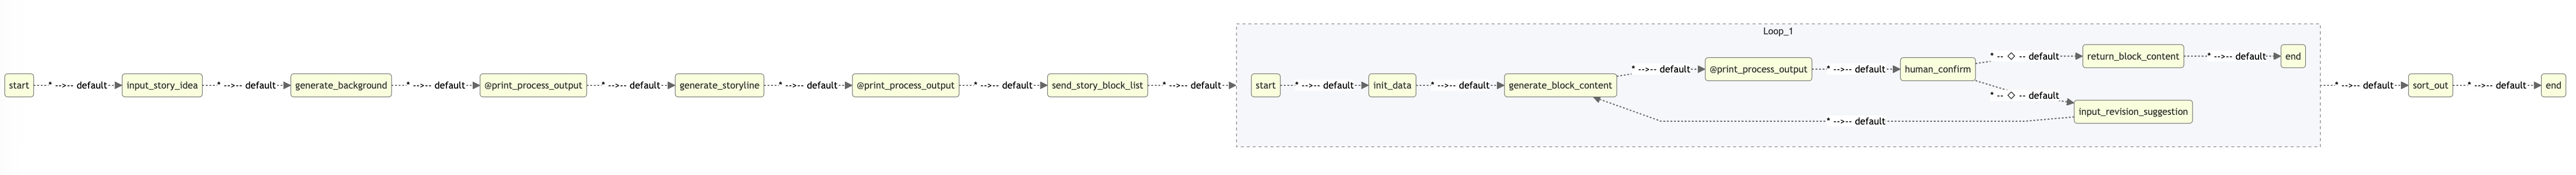

In [19]:
# 开始执行
result = main_workflow.start()
print(result["default"])

[💡请输入您的故事灵感]:  星际争霸世界观下的人类小兵的成长故事


[世界观背景故事]:
{
    "世界名称": "星际争霸宇宙",
    "主要国家或地区": [
        {
            "名称": "泰伦联邦",
            "关键信息": "位于克普鲁星区，环境多样，从沙漠到冰原，科技水平高，信仰多样，以人类至上主义为主。"
        },
        {
            "名称": "凯尔-莫拉联合体",
            "关键信息": "由多个外星种族组成，环境以森林和山脉为主，科技水平与泰伦联邦相当，信仰以自然和谐为核心。"
        },
        {
            "名称": "异虫巢群",
            "关键信息": "遍布多个星系，环境适应性强，科技以生物进化为主，无明确信仰，以生存和扩张为唯一目标。"
        }
    ],
    "世界背景故事": [
        "2480年，泰伦联邦在克普鲁星区建立殖民地，开始了人类的新篇章。",
        "2490年，凯尔-莫拉联合体与泰伦联邦建立外交关系，促进了星际间的科技和文化交流。",
        "2500年，异虫巢群首次出现在克普鲁星区，引发了人类和联合体的联合抵抗。",
        "2510年，泰伦联邦内部发生分裂，形成了多个派系，加剧了星区的政治动荡。",
        "2520年，人类小兵在多次与异虫的战斗中成长，逐渐成为抵抗异虫的中坚力量。",
        "2530年，泰伦联邦与凯尔-莫拉联合体共同研发新型武器，有效遏制了异虫的扩张。",
        "2540年，星际间的和平协议签署，但各方仍保持警惕，以防异虫的再次入侵。"
    ]
}
[关键情节线]:
{
    "情节结构类型": "三幕结构",
    "情节结构特点": "三幕结构是戏剧和电影中常见的故事结构，包括第一幕的设定和引入，第二幕的冲突和对抗，以及第三幕的高潮和解决。这种结构有助于清晰地展现故事的发展和角色的成长。",
    "故事线详细创作": [
        {
            "本段故事作用": "引入和设定",
            "关键情节": [
                "主角在泰伦联邦的军事训练

[您是否还有其他创作指导说明？如创作风格、注意事项等] 主角的名字设定成麦克，战友的名字设定成杰芬，我比较喜欢Lovecraft的克苏鲁系神话风格，可以在创作的时候尝试加入这类风格


[本轮创作目标：引入和设定]:
在泰伦联邦的军事训练营中，麦克的名字并不响亮。他的表现平平，如同大多数新兵一样，默默无闻。然而，命运的齿轮在某个不经意的瞬间开始转动。一次偶然的模拟战斗中，麦克面对虚拟的异虫巢群，他的反应速度和战术判断远超预期，仿佛他的血液中流淌着古老的战斗智慧。这一幕被上级指挥官敏锐地捕捉到，他的眼中闪过一丝期待。

“麦克，你的表现很有潜力。” 上级指挥官的声音在训练结束后响起，他的目光如鹰隼般锐利，“你将被分配到前线部队，那里才是真正考验你的地方。”

麦克的心中涌起一股复杂的情绪，既有对未知的恐惧，也有对挑战的渴望。他知道，前线的战场不同于训练场，那里的异虫巢群是真实而残酷的。

不久，麦克和他的战友杰芬一起被派往前线。当他们首次接触到真实的异虫巢群时，那种压迫感和恐怖感如同克苏鲁神话中的深海巨兽，无声地吞噬着新兵们的勇气。然而，麦克的心中却涌现出一种奇异的平静，仿佛他早已预见了这一刻。

在第一次战斗中，麦克的指挥冷静而果断，他利用地形和战术，成功地引导战友们击退了异虫的进攻。他的表现不仅赢得了战友们的尊敬，也引起了上级指挥官的进一步关注。

“麦克，你的战术运用得很好。” 上级指挥官在战后的简报中赞许道，“继续保持，你的潜力远不止于此。”

麦克点了点头，他的心中充满了对未来的期待和对未知的敬畏。他知道，这场战争只是开始，而他，麦克，将在这场与异虫的较量中，逐渐揭开自己命运的神秘面纱。


[您是否满意本次创作结果？(y/n)]:  n
[请输入您的修改意见]:  1. 上级指挥官加一个名字，叫凯恩；2. 风格使用克苏鲁神话风格，但在文中不要出现“克苏鲁”这样的字样；3. 第一次战斗的过程描述不够清晰，添加更多的战斗细节，展现战斗的残酷


[本轮创作目标：引入和设定]:
在泰伦联邦的军事训练营中，麦克的名字并不响亮。他的表现平平，如同大多数新兵一样，默默无闻。然而，命运的齿轮在某个不经意的瞬间开始转动。一次偶然的模拟战斗中，麦克面对虚拟的异虫巢群，他的反应速度和战术判断远超预期，仿佛他的血液中流淌着古老的战斗智慧。这一幕被上级指挥官凯恩敏锐地捕捉到，他的眼中闪过一丝期待。

“麦克，你的表现很有潜力。” 凯恩的声音在训练结束后响起，他的目光如鹰隼般锐利，“你将被分配到前线部队，那里才是真正考验你的地方。”

麦克的心中涌起一股复杂的情绪，既有对未知的恐惧，也有对挑战的渴望。他知道，前线的战场不同于训练场，那里的异虫巢群是真实而残酷的。

不久，麦克和他的战友杰芬一起被派往前线。当他们首次接触到真实的异虫巢群时，那种压迫感和恐怖感如同深海中的不可名状之物，无声地吞噬着新兵们的勇气。然而，麦克的心中却涌现出一种奇异的平静，仿佛他早已预见了这一刻。

在第一次战斗中，麦克的指挥冷静而果断。他利用地形和战术，巧妙地引导战友们避开异虫的正面冲击，转而攻击它们的侧翼。战斗异常激烈，异虫的嘶吼声和枪炮的轰鸣交织在一起，空气中弥漫着硝烟和血腥味。麦克的耳边回响着凯恩的教诲，他的每一个决策都显得异常关键。在一次关键的反击中，麦克亲自带领一小队士兵，利用烟雾弹掩护，成功地突破了异虫的防线，击溃了它们的指挥中枢。

“麦克，你的战术运用得很好。” 凯恩在战后的简报中赞许道，“继续保持，你的潜力远不止于此。”

麦克点了点头，他的心中充满了对未来的期待和对未知的敬畏。他知道，这场战争只是开始，而他，麦克，将在这场与异虫的较量中，逐渐揭开自己命运的神秘面纱。


[您是否满意本次创作结果？(y/n)]:  y


[本轮创作目标：冲突和对抗]:
麦克站在战场的废墟中，四周是异虫残破的尸体和燃烧的残骸。他的战甲上沾满了血迹和污泥，但他的眼神却异常坚定。经过多次与异虫的战斗，麦克已经从小队中的一名普通士兵成长为核心成员。他的战术眼光和战斗技巧在每一次交锋中都得到了提升，队友们对他的信任也日益加深。

“麦克，你还好吗？”杰芬的声音从通讯器中传来，他的语气中带着关切。

“我还好，杰芬。只是...这场战斗比我们预想的要艰难。”麦克回应道，他的目光扫过战场，寻找着任何可能的威胁。

泰伦联邦内部的动荡让麦克感到不安。政治斗争的阴影笼罩在每个人的心头，而麦克必须在忠诚于联邦和坚持自己的信念之间做出选择。这种内心的挣扎让他夜不能寐，但他知道，无论选择哪条路，他都必须坚定地走下去。

在一次与凯尔-莫拉联合体的联合行动中，麦克与他们的战士并肩作战。这些战士的战斗风格与泰伦联邦的士兵截然不同，但他们对异虫的仇恨却是相同的。在一次短暂的休息中，麦克与一名凯尔-莫拉的战士坐在一起。

“你们为什么要与我们合作？”麦克问道，他的声音中带着好奇。

“因为我们有共同的敌人，麦克。异虫是我们所有人的威胁。”那名战士回答，他的眼神坚定而冷酷。

在一次关键战役中，麦克失去了杰芬。当他在战场上找到杰芬的遗体时，他的心中充满了痛苦和愤怒。他紧紧握住杰芬的手，低声说道：“我会为你报仇的，杰芬。我会让这些异虫付出代价。”

从那一刻起，麦克的决心更加坚定。他知道，这场战争远未结束，而他，麦克，将继续在这场与异虫的较量中，揭开自己命运的神秘面纱。他的心中充满了对未知的敬畏，但他也明白，只有通过不断的战斗和牺牲，他才能找到真正的答案。


[您是否满意本次创作结果？(y/n)]:  y


[本轮创作目标：高潮和解决]:
麦克站在泰伦联邦的研发中心，眼前是一排排闪烁着蓝光的仪器和忙碌的科学家们。他的心中充满了对未知的敬畏，但他也明白，只有通过不断的战斗和牺牲，他才能找到真正的答案。新型武器的研发已经进入最后阶段，这是对抗异虫扩张的关键。

“麦克，你准备好了吗？”杰芬走过来，拍了拍他的肩膀。

“当然，杰芬。我们不能让这些异虫继续扩张下去。”麦克坚定地回答。

在接下来的几周里，麦克和杰芬与科学家们一起，日以继夜地工作，终于完成了新型武器的研发。这种武器能够有效地抑制异虫的繁殖和扩张，是泰伦联邦对抗异虫的最后希望。

最终战役的前夜，麦克站在指挥舰的甲板上，望着星空。他的心中充满了紧张和期待。他知道，明天的战斗将决定星际间的未来。

“麦克，你看起来很紧张。”泰伦联邦的高层走过来，关切地问道。

“是的，长官。这是我第一次面对如此大规模的战斗。”麦克坦诚地回答。

“记住，麦克，你不是一个人在战斗。我们都在你身边。”高层鼓励道。

第二天，战斗开始了。麦克和杰芬带领着他们的部队，冲向异虫的巢穴。新型武器发挥了巨大的作用，异虫的扩张被成功遏制。经过几个小时的激战，泰伦联邦取得了胜利。

战斗结束后，麦克站在战场上，望着满目疮痍的景象，心中充满了复杂的情感。他知道，这场胜利只是暂时的，真正的和平还需要更多的努力。

在星际间的和平协议签署仪式上，麦克被授予英雄的称号。他站在台上，望着台下的众人，心中充满了感慨。

“麦克，你成为了我们的英雄。”凯尔-莫拉联合体的领袖走上前来，微笑着说道。

“谢谢，但我只是做了我应该做的事情。”麦克谦虚地回答。

仪式结束后，麦克独自一人走在星际港口的甲板上，望着远处的星空。他反思着自己的战争经历，决定继续为和平而战。他知道，真正的答案还在前方，而他将继续追寻。


[您是否满意本次创作结果？(y/n)]:  y


在泰伦联邦的军事训练营中，麦克的名字并不响亮。他的表现平平，如同大多数新兵一样，默默无闻。然而，命运的齿轮在某个不经意的瞬间开始转动。一次偶然的模拟战斗中，麦克面对虚拟的异虫巢群，他的反应速度和战术判断远超预期，仿佛他的血液中流淌着古老的战斗智慧。这一幕被上级指挥官凯恩敏锐地捕捉到，他的眼中闪过一丝期待。

“麦克，你的表现很有潜力。” 凯恩的声音在训练结束后响起，他的目光如鹰隼般锐利，“你将被分配到前线部队，那里才是真正考验你的地方。”

麦克的心中涌起一股复杂的情绪，既有对未知的恐惧，也有对挑战的渴望。他知道，前线的战场不同于训练场，那里的异虫巢群是真实而残酷的。

不久，麦克和他的战友杰芬一起被派往前线。当他们首次接触到真实的异虫巢群时，那种压迫感和恐怖感如同深海中的不可名状之物，无声地吞噬着新兵们的勇气。然而，麦克的心中却涌现出一种奇异的平静，仿佛他早已预见了这一刻。

在第一次战斗中，麦克的指挥冷静而果断。他利用地形和战术，巧妙地引导战友们避开异虫的正面冲击，转而攻击它们的侧翼。战斗异常激烈，异虫的嘶吼声和枪炮的轰鸣交织在一起，空气中弥漫着硝烟和血腥味。麦克的耳边回响着凯恩的教诲，他的每一个决策都显得异常关键。在一次关键的反击中，麦克亲自带领一小队士兵，利用烟雾弹掩护，成功地突破了异虫的防线，击溃了它们的指挥中枢。

“麦克，你的战术运用得很好。” 凯恩在战后的简报中赞许道，“继续保持，你的潜力远不止于此。”

麦克点了点头，他的心中充满了对未来的期待和对未知的敬畏。他知道，这场战争只是开始，而他，麦克，将在这场与异虫的较量中，逐渐揭开自己命运的神秘面纱。

麦克站在战场的废墟中，四周是异虫残破的尸体和燃烧的残骸。他的战甲上沾满了血迹和污泥，但他的眼神却异常坚定。经过多次与异虫的战斗，麦克已经从小队中的一名普通士兵成长为核心成员。他的战术眼光和战斗技巧在每一次交锋中都得到了提升，队友们对他的信任也日益加深。

“麦克，你还好吗？”杰芬的声音从通讯器中传来，他的语气中带着关切。

“我还好，杰芬。只是...这场战斗比我们预想的要艰难。”麦克回应道，他的目光扫过战场，寻找着任何可能的威胁。

泰伦联邦内部的动荡让麦克感到不安。政治斗争的阴影笼罩在每个人的心头，而麦克必须在忠诚于联邦和坚持自己的信念之间做出选择。这种内心的挣扎让他夜不能寐，但他知道，无论选择哪条

### 5.3 进一步思考和讨论

以下讨论点全部为开放性讨论，没有标准的正确答案，仅作为启发思考和开拓思路的作用

- 使用LangGraph是否可以复现上面的工作流？
- 世界背景和故事线是否也可以引入人类讨论协作的机制？该怎么改写？
- 是否可以像翻译项目一样，引入反思机制？如果可以，反思机制应该如何设计？
- 还有没有更好的故事创作工作流设计？
- 你还有哪些好的工作流点子？学完本课之后，还有哪些创作难点？

## 🔄 这节课学完之后，记得恢复环境

In [ ]:
# 因为本课使用的langgraph可能需要依赖langchain 0.2.10版本，但其他课件依赖langchain 0.1.20版本
# 请学习完本课之后对langchain进行降级，以免在其他课程出现运行错误
!pip install langchain==0.1.20
!pip install langchain-openai==0.1.6
!pip install langchain-community==0.0.38